In [1]:
%matplotlib inline

import os, sys, gc
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from collections import Counter

from multiprocessing import Pool, Process

import itertools
from modules.kidera import score_positions, score_sequence

import warnings
warnings.filterwarnings('ignore')

In [2]:
fdict = {}
for key in os.listdir("data/fasta/"):
    if key.startswith("UP0"):
        fdict[key] = "Human"
    else:
        fdict[key] = key.strip("strain.fasta").strip("_")
fdict

{'CLMDtrachomatis_strain.fasta': 'CLMDtrachomatis',
 'CLOSdificile_strain.fasta': 'CLOSdificile',
 'CMV_StrainAD169.fasta': 'CMV_StrainAD169',
 'CPBTjejuni_strain.fasta': 'CPBTjejuni',
 'EBV_StrainAG876.fasta': 'EBV_StrainAG876',
 'HCV_StrainIsolateH.fasta': 'HCV_StrainIsolateH',
 'HIV-1_StrainHXB2.fasta': 'HIV-1_StrainHXB2',
 'KLEBpneumoniae_strain.fasta': 'KLEBpneumoniae',
 'MYBTsmegmatis_strain.fasta': 'MYBTsmegmatis',
 'MYPLpneumoniae_strain.fasta': 'MYPLpneumoniae',
 'MYPLsynoviae_strain.fasta': 'MYPLsynoviae',
 'SHGLflexneri_strain.fasta': 'SHGLflexneri',
 'SHGLsonnei_strain.fasta': 'SHGLsonnei',
 'SLMLenteritidis_strain.fasta': 'SLMLenteritidis',
 'SLMLtyphimurium_strain.fasta': 'SLMLtyphimurium',
 'UP000005640_9606.fasta': 'Human',
 'YERSenterocolitica_strain.fasta': 'YERSenterocolitica',
 'YERSpseudotuberculosis_strain.fasta': 'YERSpseudotuberculosis',
 'YFV_Strain17D.fasta': 'YFV_Strain17D'}

In [3]:
def aa_count(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    aa_dict  = Counter()
    for key in record_dict.keys():
        aa_dict = aa_dict + Counter(record_dict[key].seq)
    return pd.DataFrame.from_dict(aa_dict, orient='index', columns=[species]) / sum(aa_dict.values())
    
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_count, fdict.items())

df = pd.concat(result, axis=1)
df = df.drop(["*", "U", "X"])
df = df.reset_index()

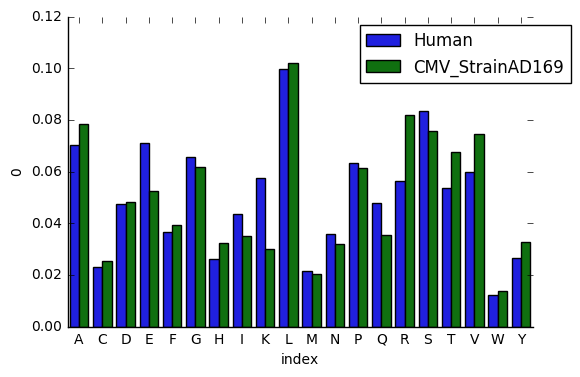

In [4]:
def plot_v_hum(df, target, ax1):
    pdf = df[['index', 'Human', target]]
    tidy = (
        pdf.set_index('index')
        .stack()  # un-pivots the data 
        .reset_index()  # moves all data out of the index
            )
    sns.barplot(x='index', y=0, hue='level_1', data=tidy, ax=ax1)
    sns.despine(fig)
    ax1.legend(loc='upper right', bbox_to_anchor=(1.1, 1))
    
fig, ax1 = plt.subplots(figsize=(6, 4))    
plot_v_hum(df, fdict[[i for i in fdict.keys()][4]], ax1)

In [5]:
df.head()

,index,SHGLsonnei,CPBTjejuni,HIV-1_StrainHXB2,EBV_StrainAG876,CMV_StrainAD169,KLEBpneumoniae,SHGLflexneri,SLMLenteritidis,YERSpseudotuberculosis,HCV_StrainIsolateH,MYBTsmegmatis,MYPLsynoviae,MYPLpneumoniae,Human,CLMDtrachomatis,YFV_Strain17D,CLOSdificile,YERSenterocolitica,SLMLtyphimurium
0,A,0.094127,0.067906,0.063061,0.091078,0.078474,0.103668,0.093315,0.098198,0.092890,0.093602,0.129433,0.058818,0.066509,0.070138,0.075095,0.071533,0.053585,0.094090,0.097446
1,C,0.011663,0.012137,0.019058,0.019597,0.025485,0.010926,0.012127,0.011516,0.010163,0.033407,0.008109,0.003958,0.007387,0.022992,0.016213,0.018763,0.012451,0.010402,0.011695
2,D,0.051743,0.052618,0.038117,0.045627,0.048232,0.051485,0.050057,0.052052,0.051875,0.038449,0.063145,0.052661,0.050370,0.047298,0.045143,0.046321,0.057051,0.051163,0.051924
3,E,0.058531,0.070209,0.071188,0.055024,0.052301,0.054475,0.057833,0.055653,0.054393,0.037189,0.053883,0.063383,0.057727,0.070979,0.066206,0.061566,0.073924,0.054705,0.055683
4,F,0.038405,0.060078,0.024103,0.037135,0.039115,0.038693,0.038322,0.038609,0.038065,0.028049,0.030963,0.058623,0.055734,0.036522,0.048760,0.034008,0.043393,0.038091,0.038982


In [6]:
viruses = ['CMV_StrainAD169', 'YFV_Strain17D', 'HIV-1_StrainHXB2', 'HCV_StrainIsolateH', 'EBV_StrainAG876']
bacteria = ['SHGLsonnei', 'SLMLenteritidis', 'MYPLpneumoniae', 'MYBTsmegmatis', 'SLMLtyphimurium', 
            'YERSpseudotuberculosis', 'YERSenterocolitica', 'CLMDtrachomatis', 'MYPLsynoviae', 'KLEBpneumoniae',
            'CPBTjejuni', 'SHGLflexneri', 'CLOSdificile']



### PCA on total AA frequencies




Let's take a look into how different microbes and human are

In [7]:
data = df.set_index('index').T.reset_index().rename(columns = {'index': 'name'})
def group_name(name):
    if name in viruses:
        return 'virus'
    elif name in bacteria:
        return 'bacterium'
    elif name in 'Human':
        return 'human'
data.name = data.name.apply(lambda x: group_name(x))

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

pctd = pca.fit_transform(data.iloc[:, 1:])
pcdf = pd.DataFrame(data = pctd, columns = ['pc1', 'pc2'])
pcdf['name'] = data.name

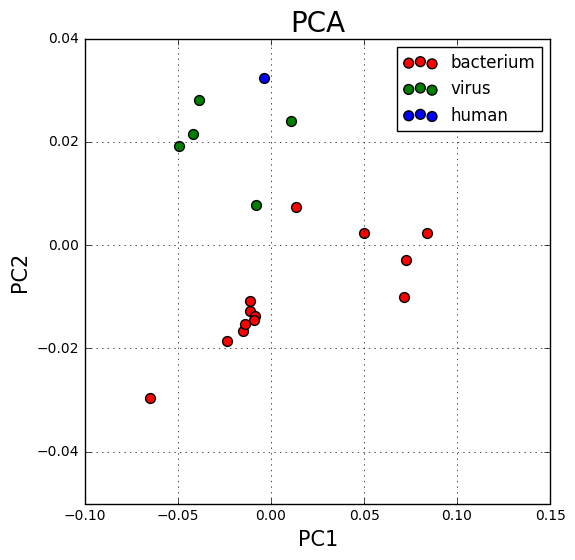

In [9]:
fig = plt.figure(figsize = (6,6))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA', fontsize = 20)

targets = pcdf.name.unique()
colours = ['r', 'g', 'b']
for target, colour in zip(targets,colours):
    indicesToKeep = pcdf['name'] == target
    ax.scatter(pcdf.loc[indicesToKeep, 'pc1']
               , pcdf.loc[indicesToKeep, 'pc2']
               , c = colour
               , s = 50)
ax.legend(targets)
ax.grid()

### PCA on AA frequencies from different proteins

In [10]:
def aa_prot_count(args):
    path, species = args
    record_dict = SeqIO.index("data/fasta/" + path, "fasta")
    aa =   ['A',
            'C',
            'D',
            'E',
            'F',
            'G',
            'H',
            'I',
            'K',
            'L',
            'M',
            'N',
            'P',
            'Q',
            'R',
            'S',
            'T',
            'V',
            'W',
            'Y']
    ignore = ["*", "U", "X"]
    df = pd.DataFrame(columns=['species', 'protein']+aa)
    aa_dict  = Counter()
    for key in tqdm(record_dict.keys()):
        aa_dict = aa_dict + Counter(record_dict[key].seq)
        for amino in list(aa_dict):
            if amino in ignore:
                del aa_dict[amino]
        df1 = pd.DataFrame.from_dict(aa_dict, orient='index').T / sum(aa_dict.values())
        df1['species'] = species
        df1['protein'] = key
        df = pd.concat([df, df1])
    return df
    
with Pool(processes=len(fdict)) as pool:
    result = pool.map(aa_prot_count, fdict.items())

df = pd.concat(result, axis=1)
df = df.fillna(0)
df = df.reset_index()

1it [00:00, 13.36it/s]
2it [00:00, 26.79it/s]
6it [00:00, 56.74it/s]
40it [00:00, 96.23it/s]
190it [00:00, 252.38it/s]
986it [00:03, 265.02it/s]
949it [00:03, 238.38it/s]
769it [00:04, 175.54it/s]
1713it [00:09, 173.26it/s]
3892it [00:15, 257.18it/s]
4047it [00:15, 257.59it/s]
4815it [00:19, 240.60it/s]
4062it [00:21, 185.35it/s]
5573it [00:22, 250.54it/s]
5761it [00:22, 253.24it/s]
6892it [00:27, 247.80it/s]
4328it [00:29, 146.51it/s]
5205it [00:30, 146.93it/s]
21033it [01:40, 209.60it/s]


KeyboardInterrupt: 

In [11]:
# aa =   ['A',
#         'C',
#         'D',
#         'E',
#         'F',
#         'G',
#         'H',
#         'I',
#         'K',
#         'L',
#         'M',
#         'N',
#         'P',
#         'Q',
#         'R',
#         'S',
#         'T',
#         'V',
#         'W',
#         'Y']
# df2 = pd.DataFrame(columns=['species', 'protein']+aa)
# df1 = pd.DataFrame.from_dict(Counter('acdefghiklmnp'), orient='index').T
# df1['species'] = 'wonder'
# df1['protein'] = 'something'
# df3 = pd.DataFrame.from_dict(Counter('acdefghiklmnp'), orient='index').T
# df3['species'] = 'wonder'
# df3['protein'] = 'something'
# d = pd.concat([df2, df1, df3])
# d